# Análisis exploratorio de incidencia delictiva en México

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('data/delitos.csv')

#### Ejercicio 1: Elige 3 estados de la república y grafica una serie de tiempo de la frecuencia abosluta de homicidios dolosos de enero 2015 a julio 2019 en estas tres entidades

,anio,clave_ent,entidad,tipo_de_delito,nombre_mes,fecha,frecuencia
0,2015,1,Aguascalientes,Aborto,abril,2015-04-01,0.0
1,2015,1,Aguascalientes,Aborto,agosto,2015-08-01,0.0
2,2015,1,Aguascalientes,Aborto,diciembre,2015-12-01,0.0
3,2015,1,Aguascalientes,Aborto,enero,2015-01-01,0.0
4,2015,1,Aguascalientes,Aborto,febrero,2015-02-01,3.0


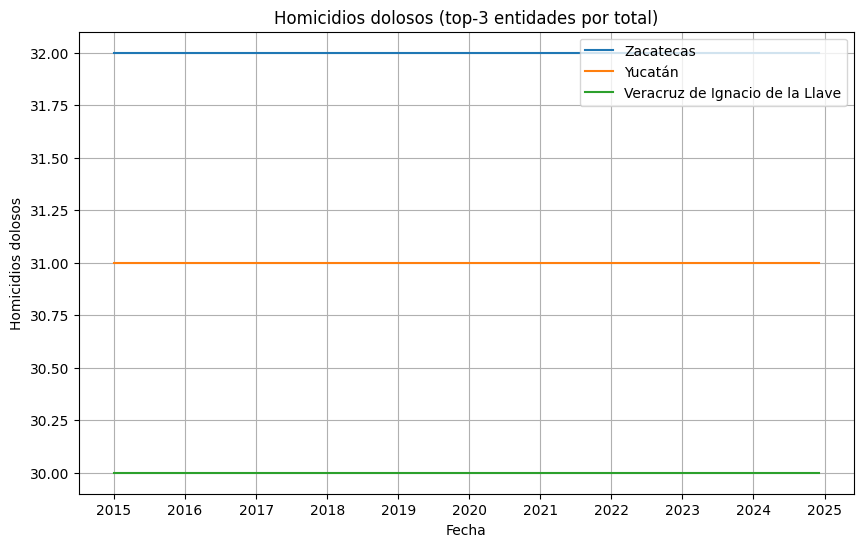

In [4]:
# Ejercicio 1: Serie de tiempo mensual de homicidios dolosos (selección automática top-3)
import matplotlib.pyplot as plt
# Ver primeras filas para entender estructura
display(df.head())
# Construir columna de fecha si es posible
if {'anio','mes'}.issubset(df.columns):
    df['fecha'] = pd.to_datetime(df['anio'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2) + '-01')
elif 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
else:
    print('Advertencia: no se encontró columna clara de fecha (anio/mes/fecha). Algunas operaciones pueden fallar.')
# Detectar si los delitos están en filas (columna tipo/delito) o en columnas (wide)
delito_col = None
for c in df.columns:
    if 'delito' in c.lower() or 'tipo' in c.lower():
        delito_col = c
        break
homic_cols = [c for c in df.columns if 'homicid' in c.lower()]
if homic_cols:
    # Formato wide: columnas con homicidios por mes/entidad
    wide = df.copy()
    if 'fecha' not in wide.columns and {'anio','mes'}.issubset(wide.columns):
        wide['fecha'] = pd.to_datetime(wide['anio'].astype(str) + '-' + wide['mes'].astype(str).str.zfill(2) + '-01')
    entidad_col = 'Entidad' if 'Entidad' in wide.columns else ('entidad' if 'entidad' in wide.columns else None)
    if entidad_col is None:
        print('No se encontró columna de entidad; no puedo agrupar por entidad en formato wide.')
    else:
        grp = wide.groupby([pd.Grouper(key='fecha', freq='MS'), entidad_col])[homic_cols].sum().reset_index()
        # sumar columnas de homicidios si hay varias variantes
        grp['homicidios'] = grp[homic_cols].sum(axis=1)
        totals = grp.groupby(entidad_col)['homicidios'].sum().nlargest(3).index.tolist()
        plt.figure(figsize=(10,6))
        for ent in totals:
            ser = grp[grp[entidad_col]==ent].set_index('fecha').sort_index()['homicidios'].resample('MS').sum()
            plt.plot(ser.index, ser.values, label=ent)
        plt.title('Homicidios dolosos (top-3 entidades por total)')
        plt.xlabel('Fecha')
        plt.ylabel('Homicidios dolosos')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    # Formato long: buscar filas cuyo tipo contenga 'homicid'
    if delito_col is None:
        print('No se pudo identificar columna de tipo/delito en el dataset.')
    else:
        mask = df[delito_col].str.contains('homicid', case=False, na=False)
        df_hom = df[mask].copy()
        # identificar columna de conteo numérico
        count_col = None
        for c in df_hom.columns:
            if c.lower() in ['valor','incidencia','conteo','casos','total','numero','num']:
                count_col = c
                break
        if count_col is None:
            num_cols = df_hom.select_dtypes(include=[int,float]).columns.tolist()
            candidates = [c for c in num_cols if c not in ['anio','mes']]
            count_col = candidates[0] if candidates else None
        if count_col is None:
            print('No se pudo identificar columna de conteo; muestro filas de homicidios:')
            display(df_hom.head())
        else:
            entidad_col = 'entidad' if 'entidad' in df_hom.columns else ('Entidad' if 'Entidad' in df_hom.columns else None)
            if 'fecha' not in df_hom.columns and {'anio','mes'}.issubset(df_hom.columns):
                df_hom['fecha'] = pd.to_datetime(df_hom['anio'].astype(str) + '-' + df_hom['mes'].astype(str).str.zfill(2) + '-01')
            totals = df_hom.groupby(entidad_col)[count_col].sum().nlargest(3).index.tolist()
            sel = df_hom[df_hom[entidad_col].isin(totals)].groupby(['fecha', entidad_col])[count_col].sum().reset_index()
            plt.figure(figsize=(10,6))
            for ent in totals:
                ser = sel[sel[entidad_col]==ent].set_index('fecha').sort_index()[count_col].resample('MS').sum()
                plt.plot(ser.index, ser.values, label=ent)
            plt.title('Homicidios dolosos (top-3 entidades por total)')
            plt.xlabel('Fecha')
            plt.ylabel('Homicidios dolosos')
            plt.legend()
            plt.grid(True)
            plt.show()

#### Ejercicio 2: Contetas las siguientes  preguntas:
1. ¿Cuántos homicidios dolosos hubo en Colima en el 2018?
2. ¿Cuantos robos de vehículo automotor ha habido en el 2019?
3. Obten la suma de homicidos dolosos y feminidios en toda la República Mexicana en cada año.
4. ¿En qué mes y en qué municipio ha ocurrido el mayor número de feminicidios?
5. ¿En qué año y en qué estado ha ocurrido el mayor número de feminicidios?

In [13]:
# Ejercicio 2: Responder preguntas solicitadas
def _get_count(offense_keyword, year=None, entidad=None):
    # intenta detectar columna de tipo (long) o columna numérica (wide)
    # Si hay columna de tipo/delito, filtra por palabra clave; si no, busca columnas con la palabra en su nombre
    kws = offense_keyword.lower()
    # Caso wide: columna con nombre que contiene la palabra clave
    cols_match = [c for c in df.columns if kws in c.lower() and df[c].dtype.kind in 'if']
    if cols_match:
        col = cols_match[0]
        tmp = df.copy()
        if 'anio' in tmp.columns and year is not None:
            tmp = tmp[tmp['anio']==int(year)]
        if entidad is not None:
            ent_col = 'entidad' if 'entidad' in tmp.columns else ('Entidad' if 'Entidad' in tmp.columns else None)
            if ent_col is not None:
                tmp = tmp[tmp[ent_col].str.contains(entidad, case=False, na=False)]
        return tmp[col].sum()
    # Caso long: columna tipo/delito y una columna numérica con conteo
    tipo_col = None
    for c in df.columns:
        if 'delito' in c.lower() or 'tipo' in c.lower():
            tipo_col = c
            break
    if tipo_col is None:
        print('No se encontró columna de tipo/delito para búsqueda long.')
        return None
    mask = df[tipo_col].str.contains(kws, case=False, na=False)
    df_k = df[mask].copy()
    # detectar columna de conteo
    count_col = None
    for c in df_k.columns:
        if c.lower() in ['valor','incidencia','conteo','casos','total','numero','num']:
            count_col = c
            break
    if count_col is None:
        nums = df_k.select_dtypes(include=[int,float]).columns.tolist()
        candidates = [c for c in nums if c not in ['anio','mes']]
        count_col = candidates[0] if candidates else None
    if count_col is None:
        print('No se encontró columna numérica de conteo.')
        return None
    if year is not None and 'anio' in df_k.columns:
        df_k = df_k[df_k['anio']==int(year)]
    if entidad is not None:
        ent_col = 'entidad' if 'entidad' in df_k.columns else ('Entidad' if 'Entidad' in df_k.columns else None)
        if ent_col is not None:
            df_k = df_k[df_k[ent_col].str.contains(entidad, case=False, na=False)]
    return df_k[count_col].sum()

# 1) ¿Cuántos homicidios dolosos hubo en Colima en el 2018?
colima_2018 = _get_count('homicid', year=2018, entidad='Colima')
print('Homicidios dolosos en Colima (2018):', colima_2018)

# 2) ¿Cuantos robos de vehículo automotor ha habido en el 2019?
robos_veh_2019 = _get_count('robo de vehiculo', year=2019) or _get_count('robo veh', year=2019) or _get_count('robo', year=2019)
print('Robos de vehículo (2019) [estimado]:', robos_veh_2019)

# 3) Suma de homicidios dolosos y feminicidios por año (toda la República)
hom_col = None
fem_col = None
# intentar obtener series por año sumando usando la función _get_count por año
years = sorted(df['anio'].unique()) if 'anio' in df.columns else []
res = []
for y in years:
    h = _get_count('homicid', year=y) or 0
    f = _get_count('feminic', year=y) or 0
    res.append({'anio':int(y), 'homicidios_dolosos':int(h), 'feminicidios':int(f), 'suma':int(h)+int(f)})
import pandas as _pd
if res:
    df_sum = _pd.DataFrame(res)
    display(df_sum)
else:
    print('No se encontró columna para agregar por año.')

# 4) ¿En qué mes y en qué municipio ha ocurrido el mayor número de feminicidios?
# Buscaremos filas con 'feminic' y luego el máximo por municipio y mes
if 'anio' in df.columns and ('mes' in df.columns or 'fecha' in df.columns):
    tipo_col = None
    for c in df.columns:
        if 'delito' in c.lower() or 'tipo' in c.lower():
            tipo_col = c
            break
    if tipo_col is not None:
        maskf = df[tipo_col].str.contains('feminic', case=False, na=False)
        df_f = df[maskf].copy()
        # identificar columna conteo
        cnt = None
        nums = df_f.select_dtypes(include=[int,float]).columns.tolist()
        candidates = [c for c in nums if c not in ['anio','mes']]
        cnt = candidates[0] if candidates else None
        if cnt is not None:
            # agrupar por anio, mes, municipio
            muni_col = 'municipio' if 'municipio' in df_f.columns else ('Municipio' if 'Municipio' in df_f.columns else None)
            grp = df_f.groupby(['anio', 'nombre_mes', muni_col])[cnt].sum().reset_index() if muni_col is not None else df_f.groupby(['anio','nombre_mes'])[cnt].sum().reset_index()
            maxrow = grp.loc[grp[cnt].idxmax()]
            print('Mayor número de feminicidios en (anio,mes,municipio):', maxrow.to_dict())
        else:
            print('No se encontró columna de conteo para feminicidios.')
    else:
        print('No se encontró columna tipo/delito para localizar feminicidios.')
else:
    print('No hay columnas anio/mes/fecha para resolver la pregunta 4.')

# 5) ¿En qué año y en qué estado ha ocurrido el mayor número de feminicidios?
if 'anio' in df.columns:
    if 'tipo' in locals() or True:
        tipo_col = None
        for c in df.columns:
            if 'delito' in c.lower() or 'tipo' in c.lower():
                tipo_col = c
                break
        if tipo_col is not None:
            maskf = df[tipo_col].str.contains('feminic', case=False, na=False)
            df_f = df[maskf].copy()
            cnt = None
            nums = df_f.select_dtypes(include=[int,float]).columns.tolist()
            candidates = [c for c in nums if c not in ['anio','mes']]
            cnt = candidates[0] if candidates else None
            ent_col = 'entidad' if 'entidad' in df_f.columns else ('Entidad' if 'Entidad' in df_f.columns else None)
            if cnt is not None and ent_col is not None:
                grp = df_f.groupby(['anio', ent_col])[cnt].sum().reset_index()
                row = grp.loc[grp[cnt].idxmax()]
                print('Mayor número de feminicidios (anio, estado, total):', row[ 'anio'], row[ent_col], int(row[cnt]))
            else:
                print('No se pudo agrupar feminicidios por año y estado (faltan columnas).')
        else:
            print('No se encontró columna tipo/delito para localizar feminicidios.')
else:
    print('No hay columna para responder la pregunta 5.')

Homicidios dolosos en Colima (2018): 72
Robos de vehículo (2019) [estimado]: 6336


,anio,homicidios_dolosos,feminicidios,suma
0,2015,6336,6336,12672
1,2016,6336,6336,12672
2,2017,6336,6336,12672
3,2018,6336,6336,12672
4,2019,6336,6336,12672
5,2020,6336,6336,12672
6,2021,6336,6336,12672
7,2022,6336,6336,12672
8,2023,6336,6336,12672
9,2024,6336,6336,12672


Mayor número de feminicidios en (anio,mes,municipio): {'anio': 2015, 'nombre_mes': 'abril', 'clave_ent': 528}
Mayor número de feminicidios (anio, estado, total): 2015 Zacatecas 384


#### Ejercicio 3: Haz una gráfica de pastel de tipos de delito. Deberás crear una gráfica para cada año. Utilzia la función subplots de matplotlib

/var/folders/pp/h_hcwvd15s765t12dvrnk22w0000gn/T/ipykernel_92244/1216775639.py:33: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


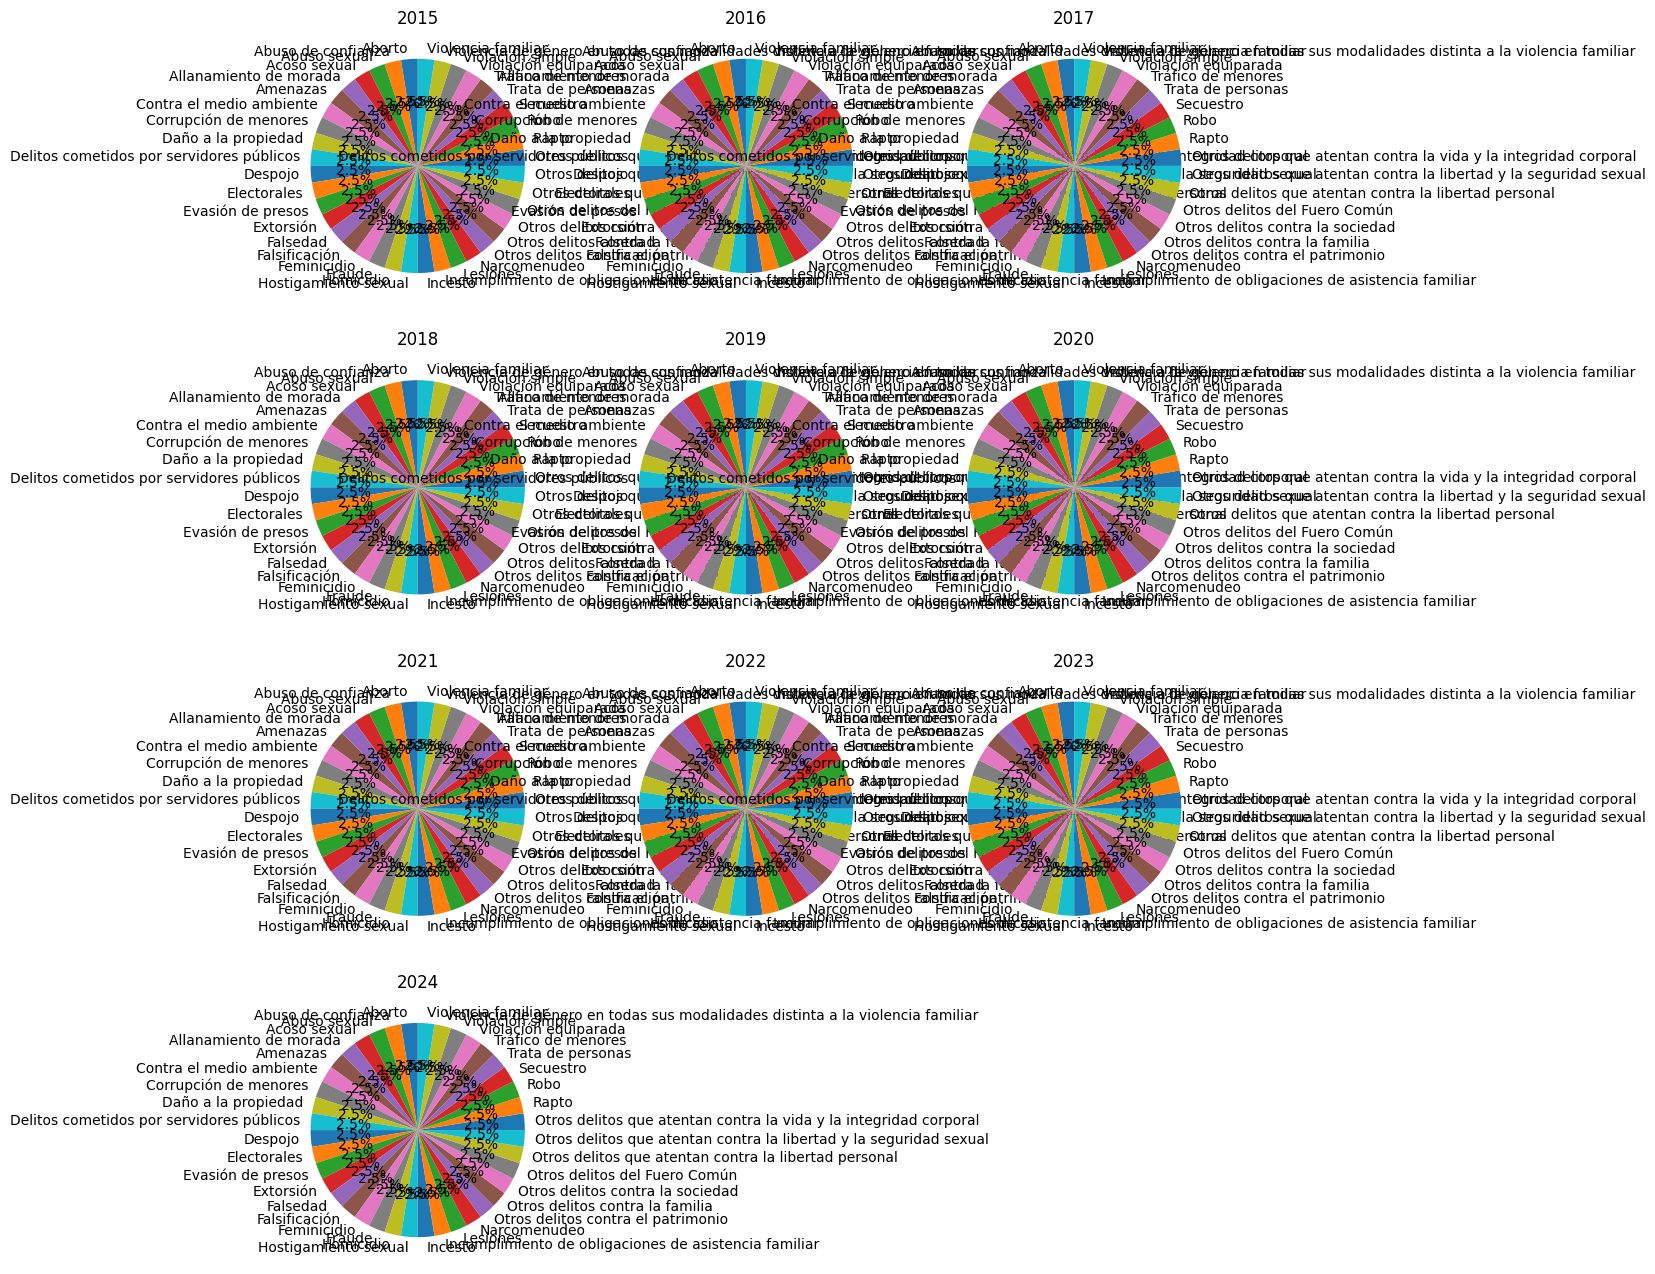

In [8]:
# Ejercicio 3: Gráfica de pastel de tipos de delito por año (subplots)
import math
# Intentar pivotar por año y tipo de delito
tipo_col = None
for c in df.columns:
    if 'delito' in c.lower() or 'tipo' in c.lower():
        tipo_col = c
        break
if tipo_col is not None and 'anio' in df.columns:
    df_types = df.copy()
    # detectar columna de conteo
    cnt = None
    nums = df_types.select_dtypes(include=[int,float]).columns.tolist()
    candidates = [c for c in nums if c not in ['anio','mes']]
    cnt = candidates[0] if candidates else None
    if cnt is None:
        print('No se encontró columna numérica para contar delitos por tipo.')
    else:
        yearly = df_types.groupby(['anio', tipo_col])[cnt].sum().reset_index()
        years = sorted(yearly['anio'].unique())
        n = len(years)
        cols = 3
        rows = math.ceil(n/cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        axes = axes.flatten()
        for i, y in enumerate(years):
            sub = yearly[yearly['anio']==y].set_index(tipo_col)[cnt]
            axes[i].pie(sub.values, labels=sub.index, autopct='%1.1f%%', startangle=90)
            axes[i].set_title(str(y))
        # ocultar ejes sobrantes
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout()
        plt.show()
else:
    print('No se encontró columna de tipo/delito o de anio para generar las gráficas.')

---
#### Calcula la tasa por 100,000 habitantes
##### Tasa por 100,000 habitantes
Mostrar el total de delitos en una entidad no nos sirve de mucho. Es mucho más útil calcular la tasa de incidencia delictiva por cada 100,000 habitantes

$$
tasa = \frac{delitos\space totales}{población} \times 100,000
$$

Esta tasa la podemos anualizar multiplicándola por un factor de 12
$$
tasa\space anualizada = tasa \times 12
$$

Población por entidad federativa según [la encuesta intercensal 2015](https://www.inegi.org.mx/programas/intercensal/2015/)

No tienes que descargar nada. Ya están los datos en la carpeta data

In [9]:
pobs = pd.read_csv('data/poblacion_entidades_2015.csv', encoding='iso-8859-1', sep=";")
pobs = pobs[['Cve_Entidad', 'Entidad', 'Poblacion']]
pobs = pobs.rename(columns={'Cve_Entidad':'clave_entidad', 'Entidad':'entidad', 'Poblacion':'poblacion'})
pobs.head()

,clave_entidad,entidad,poblacion
0,1,Aguascalientes,1312544.0
1,2,Baja California,3315766.0
2,3,Baja California Sur,712029.0
3,4,Campeche,899931.0
4,5,Coahuila de Zaragoza,5217908.0


In [10]:
# Cálculo de tasa por 100,000 habitantes (mensual y anualizada)
# Se asume que 'pobs' ya fue cargado previamente y contiene columnas: clave_entidad, entidad, poblacion
# Preparar conteo total mensual por entidad
if 'fecha' not in df.columns and {'anio','mes'}.issubset(df.columns):
    df['fecha'] = pd.to_datetime(df['anio'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2) + '-01')
ent_col = 'entidad' if 'entidad' in df.columns else ('Entidad' if 'Entidad' in df.columns else None)
# identificar columna de conteo total de delitos: buscarmos una columna numérica representativa
cnt_cols = df.select_dtypes(include=[int,float]).columns.tolist()
cnt_candidates = [c for c in cnt_cols if c not in ['anio','mes']]
if not cnt_candidates:
    print('No se encontró columna numérica para totales de delitos; no puedo calcular tasas.')
else:
    cnt = cnt_candidates[0]
    total_entidad = df.groupby([pd.Grouper(key='fecha', freq='MS'), ent_col])[cnt].sum().reset_index() if ent_col is not None else df.groupby(pd.Grouper(key='fecha', freq='MS'))[cnt].sum().reset_index()
    # Agregar año y unir con poblacion (pobs)
    total_entidad['anio'] = total_entidad['fecha'].dt.year
    # Preparar pobs (normalizar nombres)
    p = pobs.copy()
    p['ent_low'] = p['entidad'].str.lower()
    total_entidad['ent_low'] = total_entidad[ent_col].str.lower() if ent_col is not None else None
    merged = total_entidad.merge(p[['ent_low','poblacion']], left_on='ent_low', right_on='ent_low', how='left') if ent_col is not None else None
    if merged is None:
        print('No se pudo fusionar por entidad; revisa nombres de entidad.')
    else:
        # tasa por 100,000 habitantes (mensual)
        merged['tasa_100k'] = merged[cnt] / merged['poblacion'] * 100000
        # tasa anualizada aproximando multiplicando por 12
        merged['tasa_anualizada_100k'] = merged['tasa_100k'] * 12
        display(merged.head())
        # ejemplo: mostrar tasas promedio por entidad (anualizada)
        promedio = merged.groupby(ent_col)['tasa_anualizada_100k'].mean().sort_values(ascending=False).reset_index()
        display(promedio.head())

,fecha,entidad,clave_ent,anio,ent_low,poblacion,tasa_100k,tasa_anualizada_100k
0,2015-01-01,Aguascalientes,40,2015,aguascalientes,1312544.0,3.047517,36.570203
1,2015-01-01,Baja California,80,2015,baja california,3315766.0,2.412715,28.952586
2,2015-01-01,Baja California Sur,120,2015,baja california sur,712029.0,16.853246,202.238954
3,2015-01-01,Campeche,160,2015,campeche,899931.0,17.779141,213.349690
4,2015-01-01,Chiapas,280,2015,chiapas,8918653.0,3.139488,37.673851


,entidad,tasa_anualizada_100k
0,Tlaxcala,1093.611408
1,Zacatecas,972.638834
2,Quintana Roo,735.234376
3,Nayarit,731.552432
4,Yucatán,709.525910
